# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 6
# Reg-Logistic Regression, ROC, and Data Imputation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [115]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display

from IPython.display import display, Math, Latex
%matplotlib inline

## Automated Breast Cancer Detection

In this homework, we will consider the problem of early breast cancer detection from X-ray images. Specifically, given a candidate region of interest (ROI) from an X-ray image of a patient's breast, the goal is to predict if the region corresponds to a malignant tumor (label 1) or is normal (label 0). The training and test data sets for this problem is provided in the file `hw6_dataset.csv`. Each row in these files corresponds to a ROI in a patient's X-ray, with columns 1-117 containing features computed using standard image processing algorithms. The last column contains the class label, and is based on a radiologist's opinion or a biopsy. This data was obtained from the KDD Cup 2008 challenge.

The data set contain a total of 69,098 candidate ROIs, of which only 409 are malignant, while the remaining are all normal. 

*Note*: be careful of reading/treating column names and row names in this data set.

## Question 1: Beyond Classification Accuracy


0.  Split the data set into a training set and a testing set.  The training set should be 75% of the original data set, and the testing set 25%.  Use `np.random.seed(9001)`.

1. Fit a logistic regression classifier to the training set and report the  accuracy of the classifier on the test set. You should use $L_2$ regularization in logistic regression, with the regularization parameter tuned using cross-validation. 
    1. How does the fitted model compare with a classifier that predicts 'normal' (label 0) on all patients? 
    2. Do you think the difference in the classification accuracies are large enough to declare logistic regression as a better classifier than the all 0's classifier? Why or why not?
    
For applications with imbalanced class labels, in this case when there are many more healthy subjects ($Y=0$) than those with cancer ($Y=1$), the classification accuracy may not be the best metric to evaluate a classifier's performance. As an alternative, we could analyze the confusion table for the classifier. 

<ol start="3">
<li> Compute the confusion table for both the fitted classifier and the classifier that predicts all 0's.</li>
<li> Using the entries of the confusion table compute the *true positive rate* and the *true negative rate* for the two classifiers. Explain what these evaluation metrics mean for the specific task of cancer detection. Based on the observed metrics, comment on whether the fitted model is better than the all 0's classifier.</li>
<li> What is the *false positive rate* of the fitted classifier, and how is it related to its true positive and true negative rate? Why is a classifier with high false positive rate undesirable for a cancer detection task?</li>
</ol>
*Hint:* You may use the `metrics.confusion_matrix` function to compute the confusion matrix for a classification model.

In [116]:
# Data has no row continaing column names
df = pd.read_csv("./hw6_dataset.csv", header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
0,-0.144,-0.143,-0.1160,-0.1030,0.226,0.210,-0.9800,-0.780,-0.474,-0.447,...,0.925,0.516,0.34400,0.906,-1.1300,-0.552,0.553,-0.417,0.2560,0.0
1,-0.011,0.138,-0.2230,-0.1730,0.188,0.284,-0.0522,-0.256,0.129,0.427,...,-0.593,0.452,0.00785,-0.533,-0.0789,0.705,0.906,0.216,-0.0723,0.0
2,0.212,-0.313,0.2660,0.2320,-1.190,-1.150,-1.8100,-1.560,-1.250,-1.200,...,-0.816,1.570,0.39400,1.340,-1.1800,-2.700,-0.926,-2.650,-0.0447,0.0
3,0.215,-0.184,0.0274,0.0494,0.443,0.463,-1.0500,-0.941,-0.531,-0.394,...,0.634,0.111,0.37100,0.859,-0.9930,-0.492,0.363,0.326,-0.0528,0.0
4,0.279,-0.197,0.1270,0.0973,-0.213,-0.150,-1.3200,-0.994,-1.110,-1.090,...,-0.640,0.485,0.29500,0.403,-1.1200,-0.343,0.468,-0.820,0.4350,0.0


In [117]:
#  How (im)balanced is the data?
df[117].value_counts()



0.0    68689
1.0      409
Name: 117, dtype: int64

In [118]:
from sklearn.model_selection import train_test_split
np.random.seed(9001)
itrain, itest = train_test_split(range(df.shape[0]), train_size=0.75)
# Remove the last column (response) when creating Xtrain and Xtest
X_train = df.iloc[itrain, :-1]
X_test  = df.iloc[itest,  :-1]
y_train = df[117].iloc[itrain]
y_test  = df[117].iloc[itest]

/Users/sshaffer/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [119]:
# Fit a logistic regression classifier to the training set and report the accuracy of the classifier on the test set. 
# You should use  L2 regularization in logistic regression, 
# with the regularization parameter tuned using cross-validation.

logregCV = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10)))
                                ,penalty = 'l2')
logregCV.fit(X_train, y_train)

print ('Max auc_roc:', logregCV.scores_[1].max())



Max auc_roc: 0.99513748191


In [133]:
from sklearn.metrics import confusion_matrix
print ("  LogReg Train Classification accuracy is: " + str(accuracy_score(y_train, logregCV.predict(X_train))))

print ("Baseline Train Classification accuracy is: " + str(accuracy_score(y_train, np.zeros(len(X_train)))))

print ("\n\nLogReg Train Confusion Matrix:")
print (confusion_matrix(y_train, logregCV.predict(X_train), labels=None)) 

print ("\n\nLogReg Baseline Train Confusion Matrix:")
print (confusion_matrix(y_train, np.zeros(len(X_train)), labels=None))

print ("\n\n  LogReg Test Classification accuracy is: " + str(accuracy_score(y_test, logregCV.predict(X_test))))

print ("Baseline Test Classification accuracy is: " + str(accuracy_score(y_test, np.zeros(len(X_test)))))

print ("\n\nTest Confusion Matrix:")
print (confusion_matrix(y_test, logregCV.predict(X_test), labels=None)) 

print ("\n\nBaseline Test Confusion Matrix:")
print (confusion_matrix(y_test, np.zeros(len(X_test)), labels=None))



  LogReg Train Classification accuracy is: 0.995407444571
Baseline Train Classification accuracy is: 0.993883024912


LogReg Train Confusion Matrix:
[[51488    18]
 [  220    97]]


LogReg Baseline Train Confusion Matrix:
[[51506     0]
 [  317     0]]


  LogReg Test Classification accuracy is: 0.995716353111
Baseline Test Classification accuracy is: 0.994674384949


Test Confusion Matrix:
[[17176     7]
 [   67    25]]


Baseline Test Confusion Matrix:
[[17183     0]
 [   92     0]]


In [157]:
# Compute the following for both classifiers:
#   true positive rate
#   true negative rate 

tn_logregCV, fp_logregCV, fn_logregCV, tp_logregCV = confusion_matrix(y_test, 
                                                                      logregCV.predict(X_test),
                                                                      labels = None).ravel()

tpr_logregCV = tp_logregCV/(tp_logregCV + fn_logregCV)
tnr_logregCV = tn_logregCV/(tn_logregCV + fp_logregCV)

tn_base, fp_base, fn_base, tp_base = confusion_matrix(y_test, 
                                                       np.zeros(len(X_test)), 
                                                       labels = None).ravel()
                                      
tpr_base = tp_base/(tp_base + fn_base)
tnr_base = tn_base/(tn_base + fp_base)

print ("true positive rate for LogReg classifier  :  "   + str(tpr_logregCV))
print ("true positive rate for baseline classifier:  " + str(tpr_base))

print ("\ntrue negative rate for LogReg classifier  :  "   + str(tnr_logregCV))
print ("true negative rate for baseline classifier:  " + str(tnr_base))

# Compute false positive rate of the fitted classifier
fpr_logregCV = fp_logregCV/(fp_logregCV + tn_logregCV)
print ("\nfalse positive rate for LogReg classifier  :  "   + str(fpr_logregCV))


true positive rate for LogReg classifier  :  0.271739130435
true positive rate for baseline classifier:  0.0

true negative rate for LogReg classifier  :  0.999592620613
true negative rate for baseline classifier:  1.0

false positive rate for LogReg classifier  :  0.000407379386603




#### How does the fitted model compare with a classifier that predicts 'normal' (label 0) on all patients?

The accuracy of the fitted model using logistic regression (0.9954) is just marginally better than the accuracy of the all 0's classifier (0.9938)

#### Do you think the difference in the classification accuracies are large enough to declare logistic regression as a better classifier than the all 0's classifier? Why or why not? 

Based on classification accuracy metric alone, we don't think the difference in classification accuracies (0.2%) is large enough to affirm logistic regression as the better classifier.

#### Explain what these evaluation metrics (true positive rate and the true negative rate) mean for the specific task of cancer detection. 

The true positive rate, also known as Sensitivity, is the ability of the test to correctly diagnose patients who have the disease (malignant tumor in this case), given they have the disease:

$$\frac{True~Positive}{(True~Positive + False~Negative)}$$

The true negative rate, also known as Specificity, is the ability of the test to correctly diagnose patients who don’t have the disease, given they do not have the disease:

$$\frac{True~Negative}{(True~Negative + False~Positive)}$$

It's worth noting that while sensitivity and specificity are easy to measure, they're not very useful in clinical practice since a clinician doesn't know if a given patient has the disease in question or not.  This is the reason why the clinician performs the diagnostic test in the first place. Instead, the clinician wants to know, given the test result, how likely is it that the patient has the disease (positive predictive value).


#### Based on the observed metrics, comment on whether the fitted model is better than the all 0's classifier.

A different picture emerges when we compare the confusion matrices, true positive rates, and true negative rates of the two classifiers.  When making comparisons, the fitted logistic regression is clearly the better model, based on comparing the true positive rates: 27% for the logistic regression classifier vs 0% for all 0's classifier. Given that we're trying to identify a malignant tumor, a potentially fatal condition, the all 0's classifier will never predict a malignant tumor, making it a totally ineffective model.  

The true negative rates for both classifiers are almost equivalent at or around 100%, however, for such a serious condition, we'd rather have a higher true positive rates at the expense of a lower true negative rates.  While there's definitely room for improvement in logistic regression classifier's true positive rate, anything is better than 0%!


#### What is the false positive rate of the fitted classifier,  and how is it related to its true positive and true negative rate? 

The false positive rate of our fitted logistic regression classifier is ~0.0004.  The false positive rate, also know as the fall-out, is the ability of the test to incorrectly diagnose patients who don’t have the disease, given they do not have the disease:

$$\frac{False~Positive}{(False~Positive + True~Negative)}$$

Mathematically, its relation to the true negative rate is as follows:

$$ False~Positive~Rate = 1 - True~Negative~Rate$$

which we verify, our fitted logistic regression classifier yielded a 0.0004 false positive rate and a 0.9996 true negative rate.

#### Why is a classifier with high false positive rate undesirable for a cancer detection task?

A classifier with high false positive rate could be viewed as undesirable for a cancer detection task in the context that the patient who doesn't really have the disease (malignant tumor) will most likely undergo additional unnessary, and possibly invasive, tests/procedures and will feel stressed thinking they have the disease when they don't.

We view a high false negative rate as even more undesirable than a high false positive rate in the context of cancer detection since the mistake of not detecting cancer when it's present can have extreme negative consequences for the patient's mortality.

## Question 2: ROC Analysis

Another powerful diagnostic tool for class-imbalanced classification tasks is the Receiver Operating Characteristic (ROC) curve. Notice that the default logistic regression classifier in `sklearn` classifies a data point by thresholding the predicted class probability $\hat{P}(Y=1)$ at 0.5. By using a different threshold, we can adjust the trade-off between the true positive rate (TPR) and false positive rate (FPR) of the classifier. The ROC curve allows us to visualize this trade-off across all possible thresholds.


1. Display the ROC curve for the fitted classifier on the *test set*. In the same plot, also display the ROC curve for the all 0's classifier. How do the two curves compare?

2.  Compute the highest TPR that can be achieved by the classifier at each of the following FPR's, and the thresholds at which they are achieved. Based on your results, comment on how the threshold influences a classifier's FPR.
    - FPR = 0
    - FPR = 0.1
    - FPR = 0.5
    - FPR = 0.9
- Suppose a clinician told you that diagnosing a cancer patient as normal is *twice* as critical an error as diagnosing a normal patient as having cancer. Based on this information, what threshold would you recommend the clinician to use? What is the TPR and FPR of the classifier at this threshold? 

- Compute the area under the ROC curve (AUC) for both the fitted classifier and the all 0's classifier. How does the difference in the AUCs of the two classifiers compare with the difference between their classification accuracies in Question 1, Part 2(A)? 

*Hint:* You may use the `metrics.roc_curve` function to compute the ROC curve for a classification model and the `metrics.roc_auc_score` function to compute the AUC for the model.

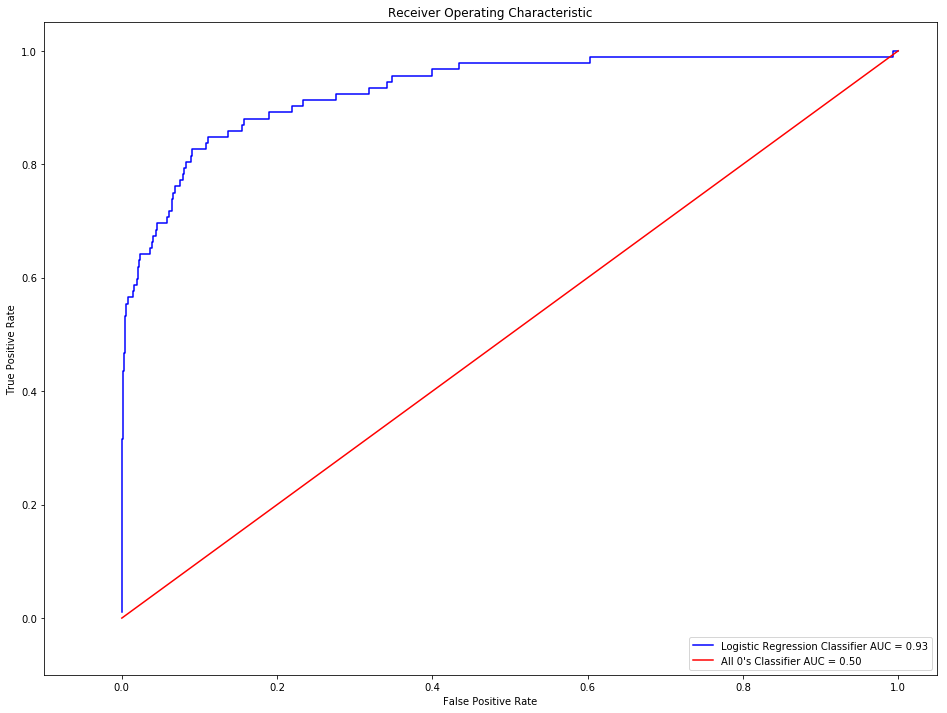

In [192]:
#making ROC curves for this model
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, logregCV.predict_proba(X_test)[:,1])

roc_auc = auc(false_positive_rate, true_positive_rate)

false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(y_test, np.zeros(len(X_test)))
roc_auc2 = auc(false_positive_rate2, true_positive_rate2)


plt.figure(figsize = (16, 12))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='Logistic Regression Classifier AUC = %0.2f'% roc_auc)
plt.plot(false_positive_rate2, true_positive_rate2, 'b', c = 'red', label='All 0\'s Classifier AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.xlim([-0.1,1.05])
plt.ylim([-0.1,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [242]:
#  Compute the highest TPR that can be achieved by the classifier at each of the following FPR's, 
#  and the thresholds at which they are achieved. 
FPRS = [0.0, 0.1, 0.5, 0.9]
#  Iterate through specified FPR thresholds
for FPR in FPRS:
    #  Iterate through false positive rate object for the fitted logistic regression classifier.
    for ind, fpr in enumerate(false_positive_rate):
        # Do we cross the pecified FPR threshold?
        if fpr - FPR > 0:
            # Yes, then grab values
            print ("\nFPR Threshold:            " + str(FPR))
            print ("False Positive Rate:      " + str(false_positive_rate[ind]))
            print ("True Positive Rate:       " + str(true_positive_rate[ind]))
            print ("Predicted Class\nProbability Threshold:    " + str(thresholds[ind]))
            print ("Index:                    " + str(ind))
            break




FPR Threshold:            0.0
False Positive Rate:      5.8197055229e-05
True Positive Rate:       0.173913043478
Predicted Class
Probability Threshold:    0.683264866243
Index:                    2

FPR Threshold:            0.1
False Positive Rate:      0.108944887389
True Positive Rate:       0.826086956522
Predicted Class
Probability Threshold:    0.0057480486594
Index:                    96

FPR Threshold:            0.5
False Positive Rate:      0.60344526567
True Positive Rate:       0.978260869565
Predicted Class
Probability Threshold:    0.000101916447651
Index:                    124

FPR Threshold:            0.9
False Positive Rate:      0.993714718035
True Positive Rate:       0.989130434783
Predicted Class
Probability Threshold:    8.6018299594e-10
Index:                    126


In [291]:
# Compute the Predicted Class Probability Threshold where:
#    Diagnosing a cancer patient as normal is twice as critical an error as 
#    diagnosing a normal patient as having cancer.
#     ==> One False Negative is 2 times less desirable than One False Positive
#    Determine the classification threshold corresponding to this

threshold = 0.0
# Iterate through theshold range
for threshold in np.arange(0.0, 1.0, 0.001):
    # Determine FN and FP from confusion matrix at specified threshold
    tn_logregCV, fp_logregCV, fn_logregCV, tp_logregCV = confusion_matrix(y_test, 
                                                                      (np.round(logregCV.predict_proba(X_test)[:,1] - threshold + 0.5)),
                                                                      labels = None).ravel()
    #  Is False Positive // False Negative = 2?
    if fp_logregCV//fn_logregCV == 2:
        # Yes, display threshold, FN, and FP
        print ("Threshold:        " + str(threshold))
        print ("False Negative:   " + str(fn_logregCV))
        print ("False Positive:   " + str(fp_logregCV))
        break
print ("\n\nTest Confusion Matrix at threshold: " + str(threshold))
print (confusion_matrix(y_test, (np.round(logregCV.predict_proba(X_test)[:,1] - threshold + 0.5)),labels = None))
tpr_logregCV = tp_logregCV/(tp_logregCV + fn_logregCV)
fpr_logregCV = fp_logregCV/(fp_logregCV + tn_logregCV)

# Compute true positive rate of the fitted classifier at threshold
print ("\ntrue positive rate at threshold " + str(threshold) + " :  " + str(tpr_logregCV))

# Compute false positive rate of the fitted classifier at threshold
fpr_logregCV = fp_logregCV/(fp_logregCV + tn_logregCV)
print ("\nfalse positive rate at threshold " + str(threshold) + ":  " + str(fpr_logregCV))



/Users/sshaffer/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


Threshold:        0.108
False Negative:   41
False Positive:   121


Test Confusion Matrix at threshold: 0.108
[[17062   121]
 [   41    51]]

true positive rate at threshold 0.108 :  0.554347826087

false positive rate at threshold 0.108:  0.00704184368271


#### How do the two ROC curves compare?

The fitted classifier ROC curve is much better, its True Positive values are always larger than the coresponding all 0's classifier ROC curve values for any given False Positive value.   The all 0's classifier ROC curve is a straight line with slope = 1 and y-intercept at x = 0, which is equivalent to a truly useless classifier, meaning, one that is no better at identifying true positives than flipping a coin, as it has an has an area of 0.5. 

#### Compute the highest TPR that can be achieved by the classifier at each of the following FPR's, and the thresholds at which they are achieved. Based on your results, comment on how the threshold influences a classifier's FPR. Based on your results, comment on how the threshold influences a classifier's FPR.

FPR | TPR |Probability Threshold|
-------------:|-------------:|-------------:|
0 | 0.1739|0.6833|
0.1| 0.8261|0.0058|
0.5| 0.9783|0.0001|
0.9| 0.9891|8.6018299594e-10|

Lowering the predicted class probability threshold corresponds to increasing a classifier's false positive rate (FPR).

#### Suppose a clinician told you that diagnosing a cancer patient as normal is twice as critical an error as diagnosing a normal patient as having cancer. Based on this information, what threshold would you recommend the clinician to use? What is the TPR and FPR of the classifier at this threshold?

Based on this criteria, we iterate through various predicted class probability thresholds between 0 and 1 to determine at which threshold the ratio of the number of False Positives to False Negative exceeds 2.  We computed a threshold = 0.108 (corresponding to False Negative: 41, False Positive: 121 in our fitted model).  The TPR and FPR of the classifier at this threshold is 0.5543 and 0.0070, respectively.

#### Compute the area under the ROC curve (AUC) for both the fitted classifier and the all 0's classifier. How does the difference in the AUCs of the two classifiers compare with the difference between their classification accuracies in Question 1, Part 2(A)?

The area under the ROC curve (AUC) for both the fitted classifier and the all 0's classifier is 0.93 and 0.5, respectively, as shown in the ROC plot.  An AUC of 0.5 corresponds to a truly useless (random) classifier as implied earlier.

z



## Question 3: Missing data

In this problem you are given a different data set, `hw6_dataset_missing.csv`, that is  similar to the one you used above (same column definitions and same conditions), however this data set contains missing values. 

*Note*: be careful of reading/treating column names and row names in this data set as well, it *may* be different than the first data set.


1. Remove all observations that contain and missing values, split the dataset into a 75-25 train-test split, and fit the regularized logistic regression as in Question 1 (use `LogisticRegressionCV` again to retune).  Report the overall classification rate and TPR in the test set.
2. Restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via mean imputation.  Split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
3. Again restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via a model-based imputation method. Once again split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
4. Compare the results in the 3 previous parts of this problem.  Prepare a paragraph (5-6 sentences) discussing the results, the computational complexity of the methods, and conjecture and explain why you get the results that you see.



## APCOMP209a - Homework Question


This problem walks you through the derivation of the **likelihood equations** for a generalized linear model (GLM). Suppose that the random component of the GLM is in the univariate natural exponential family, so that
$$f(y_i|\theta_i) = h(y_i) e^{y_i\theta_i - b(\theta_i)}$$
Define the individual log-likelihood for each observation $i$ as
$$l_i(\theta_i) \equiv \log f(y_i|\theta_i)$$
with linear predictor
$$\eta_i = x_i^T\beta = g(\mu_i)$$
for some link function $g$ and where $\mu_i=E(Y_i)$.

1. Use the above expressions to write a simplified expression for the log-likelihood $l(\theta)$ for the entire dataset, $y_1, \dots, y_n$.

2. Use the chain rule to express $\frac{\partial l_i}{\partial \beta_j}$ in terms of the derivatives of $l_i, \theta_i, \mu_i$, and $\eta_i$. (*Hint*: Think carefully about which variables are related to which, and in what way. For example, for which of the above variables do you know the derivative with respect to $\beta_j$?)

3. Compute the derivatives for $\frac{\partial l_i}{\partial \theta_i}$ and $\frac{\partial \eta_i}{\partial \beta_j}$.

4. Express $\mu_i$ in terms of $\theta_i$, and use this relationship to compute $\frac{\partial \theta_i}{\partial \mu_i}$. (\emph{Hint}: Recall the cumulant function of a natural exponential family, and assume that you can write $\partial f/\partial g = (\partial g / \partial f)^{-1}$.)

5. Express $\eta_i$ in terms of $\mu_i$. Using the same hint as the above, compute $\frac{\partial \mu_i}{\partial \eta_i}$.

6. Put all of the above parts together to write an expression for $\frac{\partial l}{\partial \beta_j}$. Use matrix notation to write this expression as
$$\nabla_{\beta} l(\beta) = XDV^{-1}(Y - \mu) = 0$$
That is, compute the matrices $D$ and $V$ such that this equation holds.

7. If we use the canonical link function, how do your answers to part (6) simplify?

8. Finally, compute the above likelihood equations in the case of logistic regression, and show that this is equivalent to the solution given in lecture.
